# Project Bootcamp Data Science 2021/2022


## Subject project : Detection of emotions on the face with Keras module.

### Autor : Krystian Siudut

## Project design:
* 1) Admission and project description
* 2) Presentation and data description
* 3) Preparation of data for convolutional network
* 4) Network learning
* 5) Checking the effectiveness of the network
* 6) Real time emotion detection based od video
* 7) Summary

## 1) Admission and project description

The aim of the project will be to recognize emotions based on facial expressions from real-time video.
Of course, I will need data for this. I will be working on a dataset called FER2013, that comes from the portal Kaggle.

Due to the fact that I will be working on pictures, I will use the convolutional network with the help of the module Keras.
The dataset, as we will see in a moment, has images that show 7 emotions:

* Angry
* Disgust
* Fear
* Happy
* Neutral
* Sad
* Surprise

Therefore it is a problem of a seven class classification 

Additionally, the label 'Disgust' is very unbalanced compared to other classes.
This can have a very negative effect on learning the network, that's why I decided to combine the label 'Disgust' with the label 'Angry'. These two emotions are quite similar and it's hard for me to tell the difference, which picture is 'Angry' and which one is 'Disgust'

## 2) Presentation and data description

##### I start by importing the libraries I need

In [3]:
import cv2
import numpy as np
import pandas as pd
import scikitplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.utils import np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### Then it will import the dataset FER2013.csv. The data is in the form of a DataFrame. 
* emotion - the column contains numbers that represent each emotion (0-6)
* pixels - stores 96 pixel values because each image has a resolution 48x48 and it is grayscale
* Usage - consists of values such as
> 'Training', 'PublicTest', 'PrivateTest' 
* Additionally, there are 35,887 non-null values in the dataset

In [6]:
data = pd.read_csv(r'.../fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


##### Display information on a dataset
Count values for a column 'Usage' and 'emotion'


In [7]:
print(data.info())
print('-'*50)
print(data['Usage'].value_counts())
print('-'*50)
print(data['emotion'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
--------------------------------------------------
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64
--------------------------------------------------
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


##### Graph showing values

The chart shows that the amount of data for the 'Disgust' label is very small

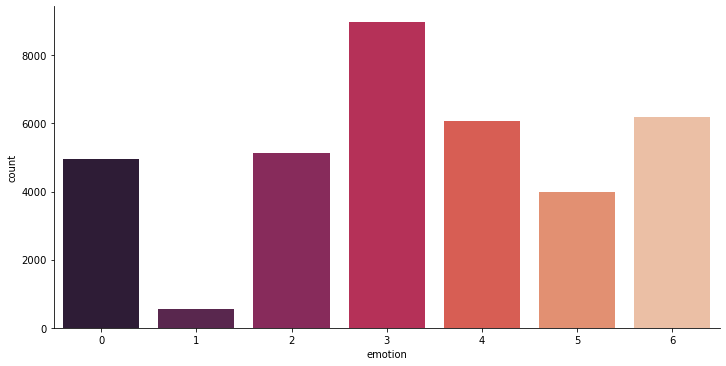

In [8]:
sns.catplot(x = 'emotion',
            kind = 'count',
            data = data[['emotion']], 
            aspect = 2,
            palette = 'rocket')

In [9]:
new_labels = {0: 'Angry',1: 'Disgust',2: 'Fear',3: 'Happy',4: 'Sad',5: 'Surprise',6: 'Neutral'}

#### The following code assigns the label 'Disgust' to the label 'Angry'

In [10]:
new_emotion = data['emotion'].replace(1,0)
new_emotion_column = pd.DataFrame(new_emotion)
data.update(new_emotion_column)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


##### Graph showing adjusted labels and counted values

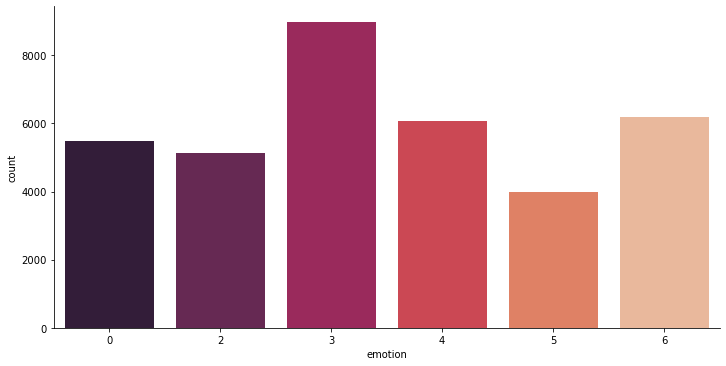

In [11]:
sns.catplot(x = 'emotion',
            kind = 'count',
            data = data[['emotion']], 
            aspect = 2,
            palette = 'rocket') 

In [12]:
print(data['emotion'].value_counts()) 
# Angry = 4953(previous value) + 547('Disgust') = 5500

3    8989
6    6198
4    6077
0    5500
2    5121
5    4002
Name: emotion, dtype: int64


##### View sample images
**The sample images show that: **
* present women, men, children, cartoon and animated characters
* they are of different races and ages
* some images show watermarks and, like the 'Fear' tag, some images do not have faces
* additionally, the images are of different quality

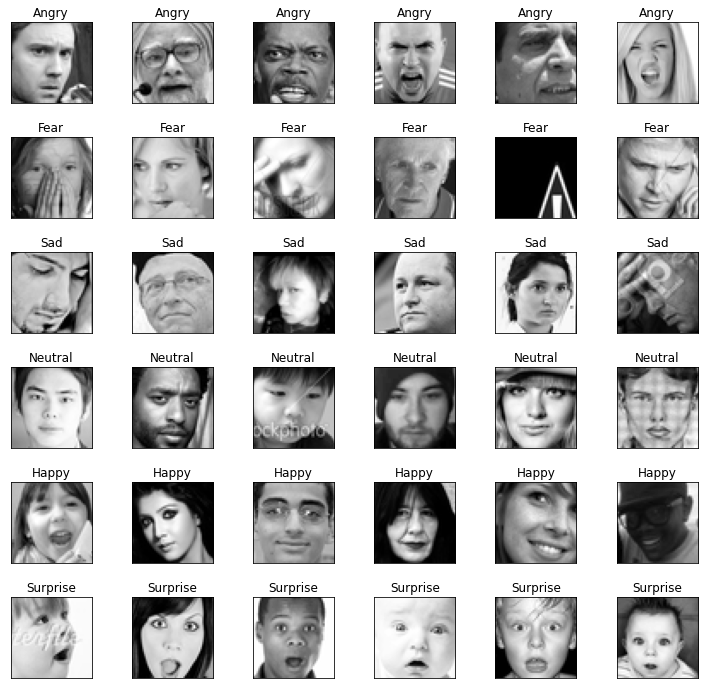

In [15]:
n = 0

size = plt.figure(1, (10 ,10))  # set the size of the images
for label in data.emotion.unique(): # loop going through each of the 7 emotions
    
    for labels in range(len(data.emotion.unique())): # a loop that follows the number of emotions
        pixel = data[data.emotion==label].pixels.iloc[n]  # reads individual images from the datafram for the emotion given on the label
        pixel = np.array(pixel.split(' ')).reshape(48, 48).astype('float64') # transform the content px (pixel values for a given emotion into an array)
        n += 1 # increment the value of k to read subsequent images for a given emotion
        
        pictures_net = plt.subplot(6, 6, n) # set the dimensions of the grid of displayable images
        plt.tight_layout() # matching dimensions between titles and displayed images
        
        pictures_net.set_xticks([]) # removing the x axis with numbers
        pictures_net.set_yticks([]) # removing the y axis with numbers
        pictures_net.set_title(new_labels[label]) # setting the titles
        pictures_net.imshow(pixel, cmap='gray') # displaying individual images (array)

## 3) Preparation of data for convolutional network

In [13]:
Le = LabelEncoder()

new_picture_scale = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float64'))
# Flattened images will be changed to 3D with the size of 48x48x1 (grayscale - one channel)
new_picture_scale = np.stack(new_picture_scale, axis=0) # aligning values along the fourth dimension


picture_labels = Le.fit_transform(data.emotion) # Converting labels using encoding 'OneHot Encoding'
picture_labels = np_utils.to_categorical(picture_labels)

name_map = dict(zip(Le.classes_, Le.transform(Le.classes_))) # mapping from previous labels to new ones
#(old labels : {0: 'Angry',1: 'Disgust',2: 'Fear',3: 'Happy',4: 'Sad',5: 'Surprise',6: 'Neutral'} )
name_map

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

#### Split the data into training data and validation data with TRAIN_TEST_SPLIT

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(new_picture_scale,
                                                      picture_labels, 
                                                      stratify=picture_labels,
                                                      shuffle=True,
                                                      test_size=0.3)

print(X_train.shape,
      X_valid.shape,
      y_train.shape,
      y_valid.shape)

(25120, 48, 48, 1) (10767, 48, 48, 1) (25120, 6) (10767, 6)


#### Data normalization

Divides the data by 255, which is the largest value for grayscale images

In [18]:
X_train = X_train / 255.
X_valid = X_valid / 255.

#### Configuration of callbacks

early_stopping - it will stop the learning process when the result stops significantly improving

In [80]:
early_stopping = EarlyStopping(monitor='val_accuracy', # monitored value
                               verbose=1, # verbosity mode
                               restore_best_weights=True, # restoration of weights from the best epoch
                               min_delta=0.0005, # minimal change of monitored value
                               patience=10, # number of epochs without improvement after which learning will stop
                              )

reduce_lr - will reduce the learning speed when the score stops improving

In [81]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', # monitored value
                              min_lr=1e-7, # lower limit of learning
                              verbose=1, # verbosity mode
                              factor=0.5, # the value by which the learning speed will decrease
                              patience=5, # the number of epochs without improvement after which the learning speed will be decreased    
                             )

### Modifying Images Using ImageDataGenerator

Additionally, I will make changes to the images. This can increase the performance of the model.

I chose a few parameters of my generator with which I can determine how the images will be rotated or how much they will be enlarged, etc.


Finally, I have to 'train' the generator using the fit method

In [15]:
data_generator = ImageDataGenerator(shear_range=0.10, # shear angle
                                    zoom_range=0.10, # zoom range
                                    horizontal_flip=True, # random flipping
                                    rotation_range=20, # degree range for random spins
                                    width_shift_range=0.10, # horizontal image shift range
                                    height_shift_range=0.10) # vertical shift range of the images

data_generator.fit(X_train)

#### Create the appropriate variables for the model

In [16]:
width = 48
height = 48
depth = 1
classes = 6
batch_size = 32 
epochs = 100

### Model building

Model configuration: 

* activation function - 'relu'
* kernel initiator - 'he_normal'
* 9 layers to normalize the input data (BatchNormalization())
* 8 convolution layers (Conv2D) with convolution window = (3,3), padding = 'same' and other filters (64,128,256,512)
* 7 layers Dropout()
* window size MaxPooling2D = (2,2)
* a flattening layer below (Flatten()), 3 basic layers Dense() with filters(256,128,64)
* The last dense layer has the activation function set to 'softmax' and the given number of starting classes
* model.compile - the optimizing function is 'adam', the loss function is 'categorical_crossentropy' and the evaluation metric is 'accuracy'


The model contains almost 6 million parameters

In [19]:
model = Sequential()


model.add(Conv2D(64,(3,3),activation='relu',input_shape=(width,height,depth),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))





model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes,activation='softmax'))





model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

## 4) Network learning

In [20]:
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
785/785 [==============================] - 612s 779ms/step - loss: 2.0313 - accuracy: 0.2057 - val_loss: 1.7383 - val_accuracy: 0.2428 - lr: 0.0010
Epoch 2/100
785/785 [==============================] - 1033s 1s/step - loss: 1.6981 - accuracy: 0.2844 - val_loss: 1.5821 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 3/100
785/785 [==============================] - 1603s 2s/step - loss: 1.5906 - accuracy: 0.3455 - val_loss: 1.4591 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 4/100
785/785 [==============================] - 5888s 8s/step - loss: 1.4399 - accuracy: 0.4173 - val_loss: 1.2619 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 5/100
785/785 [==============================] - 1061s 1s/step - loss: 1.3366 - accuracy: 0.4743 - val_loss: 1.3146 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 6/100
785/785 [==============================] - 601s 765ms/step - loss: 1.2803 - accuracy: 0.5031 - val_loss: 1.1189 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 7/100
785/785 [===========================

Epoch 51/100
785/785 [==============================] - 638s 813ms/step - loss: 0.6977 - accuracy: 0.7560 - val_loss: 0.9193 - val_accuracy: 0.6802 - lr: 5.0000e-04
Epoch 52/100
785/785 [==============================] - 641s 817ms/step - loss: 0.6985 - accuracy: 0.7569 - val_loss: 0.9408 - val_accuracy: 0.6772 - lr: 5.0000e-04
Epoch 53/100
785/785 [==============================] - 638s 812ms/step - loss: 0.6889 - accuracy: 0.7568 - val_loss: 0.9861 - val_accuracy: 0.6739 - lr: 5.0000e-04
Epoch 54/100
785/785 [==============================] - 639s 814ms/step - loss: 0.6871 - accuracy: 0.7590 - val_loss: 0.9052 - val_accuracy: 0.6848 - lr: 5.0000e-04
Epoch 55/100
785/785 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.7598
Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
785/785 [==============================] - 642s 818ms/step - loss: 0.6800 - accuracy: 0.7598 - val_loss: 0.9053 - val_accuracy: 0.6818 - lr: 5.0000e-04
Epoch 56/1

#### Save the model for future use

In [51]:
model.save("better_model.h5")

#### Loading the model

In [2]:
from keras.models import load_model
model = load_model('better_model.h5')

## 5) Checking the effectiveness of the network

#### Error matrix plot

The confusion matrix shows that the model works best in class 2, but its effectiveness is quite low in the other classes.

This may be due to the difference in the number of images or because the images themselves are not of good quality and some of them do not differ significantly from each other, for example in the Neutral and Sad classes

Accuracy test: 51.55
              precision    recall  f1-score   support

           0       0.54      0.38      0.45      1650
           1       0.33      0.63      0.43      1536
           2       0.74      0.69      0.72      2697
           3       0.54      0.28      0.37      1823
           4       0.49      0.74      0.59      1201
           5       0.49      0.36      0.42      1860

    accuracy                           0.52     10767
   macro avg       0.52      0.52      0.50     10767
weighted avg       0.55      0.52      0.51     10767



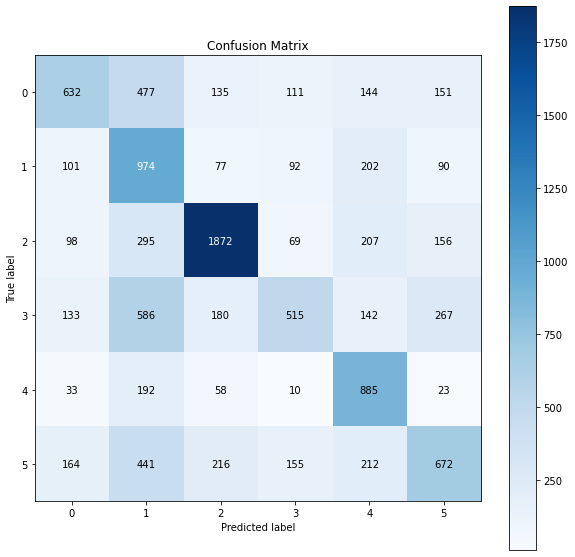

In [17]:
model_pred = np.argmax(model.predict(X_valid), axis=1)
y_val = np.argmax(y_valid, axis=1)

scikitplot.metrics.plot_confusion_matrix(y_val, model_pred, figsize=(10,10))
test_accu = np.sum(y_val == model_pred) / len(y_val) * 100


plt.savefig("confusion_matrix.png")
print(f"Accuracy test: {round(test_accu, 2)}")
print(classification_report(y_val, model_pred))

#### Code that displays the chart

In [1]:
#from IPython.display import Image
#Image(filename='confusion_matrix.png') 

##  6) Real time emotion detection based od video

#### The following code allows you to run the webcam and use the trained model to recognize emotions in sample faces

In [ ]:
emotions_labels = {0: 'Angry',1: 'Fear',2: 'Happy',3: 'Sad',4: 'Surprise',5: 'Neutral'}
cap = cv2.VideoCapture(0)
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def detect_face(frame):
    faces=classifier.detectMultiScale(frame,1.3,4)
    if faces==():
        return frame
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=emotions_labels[np.argmax(model.predict(face))],
                    org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
    return frame
while 1:
    ret,frame= cap.read()
    if ret==True:
        cv2.imshow('Detector',detect_face(frame))
        if cv2.waitKey(1)==27:
            break
cap.release()
cv2.destroyAllWindows()

#### Uploading individual images presenting the operation of the model using a video camera

In [16]:
from IPython.display import Image
angry = Image(filename=r'pictures_of_emotions/angry.png')
happy = Image(filename=r'pictures_of_emotions/happy.png')
fear = Image(filename=r'pictures_of_emotions/fear.png')
neutral = Image(filename=r'pictures_of_emotions/natural.png')
surprise = Image(filename=r'pictures_of_emotions/surprise.png')
sad = Image(filename=r'pictures_of_emotions/sad.png')

In [19]:
images = [angry, happy, fear,neutral,surprise,sad]

#### The model does not have a relatively high efficiency, but in my opinion, it mostly fulfills its task and is able to ignite the emotions shown to it.

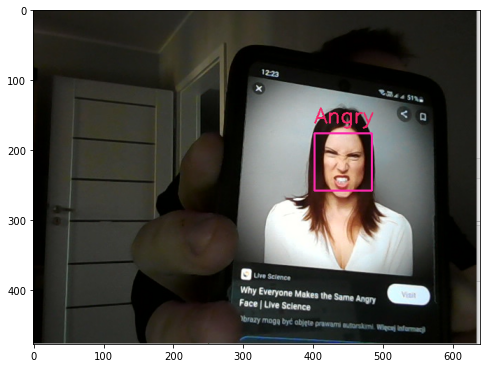

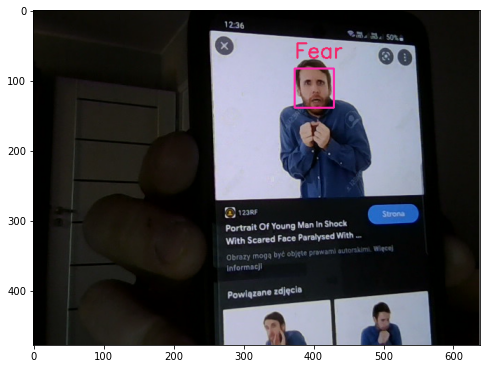

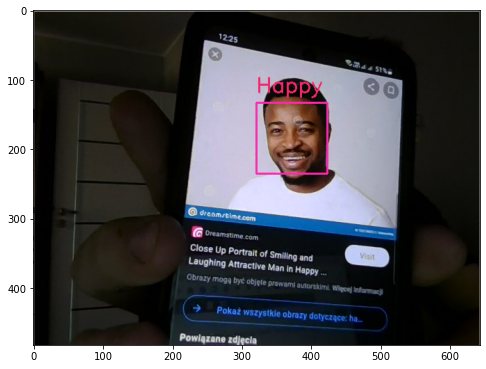

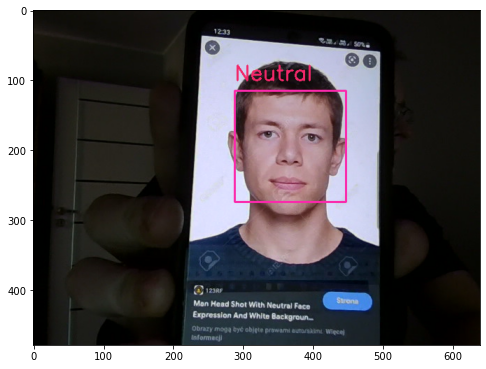

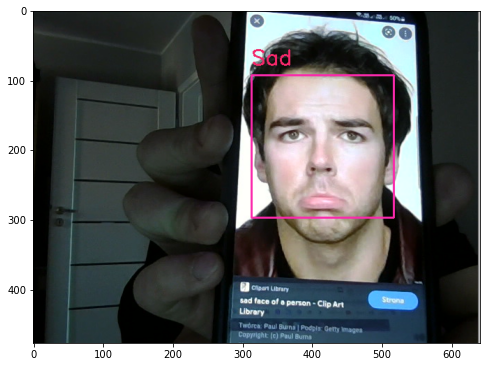

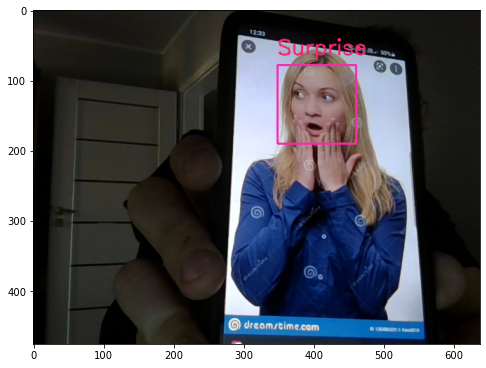

In [33]:
for i in images:
    plt.figure(figsize=(8,8))
    plt.imshow(i)

## 7) Summary

The implementation of the above project was a big challenge for me. While working with the project, I was teaching and configuring several convolutional networks, thanks to which I learned a lot of new things. In addition, I developed and recorded those already known on the bootcamp.

Searching for information on neural networks allowed me to discover how many applications these types of models have.

Thanks to the work done, future projects related to this type of networks will be much easier for me and I will be able to build much more effective networks.

The greatest difficulty in carrying out the project was building an effective network. 
The reason for this is the very long learning time of the model. On my computer, some networks even learned 2 or 3 days despite using, for example Colab

Despite the fact that the model is not as effective as I would like it to be, I am still very happy that I achieved the previously set goal of the project.